<a href="https://colab.research.google.com/github/moni6264/Deep_learning/blob/main/DL_2_PART_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
import numpy as np

!pip install wandb
import wandb
from wandb.keras import WandbCallback

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Unzip and load file data file onto server, then delete zip file for optimizing performance
zip_path = "drive/MyDrive/nature_12K.zip"
!cp "{zip_path}" .
!unzip -q nature_12K.zip


replace inaturalist_12K/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
def createCNN(num_filters=32, filter_multiplier=1, dropout=0.2, batch_norm=False, dense_size=64, num_classes=10, image_size=200):
    model = Sequential()
    
    for i in range(5):
        filter_dim = 11 - 2*i
        filter_size = (filter_dim, filter_dim)
        if i==0:
            model.add(Conv2D(num_filters, filter_size, input_shape=(image_size, image_size, 3), data_format="channels_last"))
        else:
            model.add(Conv2D(num_filters, filter_size))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        num_filters = int(num_filters * filter_multiplier)
    
    model.add(Flatten())
    model.add(Dense(dense_size))
    model.add(Dropout(dropout))
    model.add(Activation("relu"))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    return model

In [5]:
def prepare_dataset(DATA_DIR="inaturalist_12K", augment_data=False):
    train_dir = os.path.join(DATA_DIR, "train")
    test_dir = os.path.join(DATA_DIR, "val")

    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          validation_split=0.1,
                                          horizontal_flip=True)
        test_datagen = ImageDataGenerator(rescale=1./255)

    else:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
        test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(200, 200), batch_size=256, subset="training")
    val_generator = train_datagen.flow_from_directory(train_dir, target_size=(200, 200), batch_size=256, subset="validation")
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(200, 200), batch_size=256)
    
    return train_generator, val_generator, test_generator;

In [6]:
#Customise run names for WandB to enhance readability
def setRunName(num_filters=32, filter_multiplier=1, augment_data=False, dropout=0.2, batch_norm=False):
    
    augment_data_options = {True: "Y", False: "N"}
    batch_norm_options = {True: "Y", False: "N"}

    run_name = "_".join(["num", str(num_filters), "org", str(filter_multiplier), "aug", augment_data_options[augment_data],
                      "drop", str(dropout), "norm", batch_norm_options[batch_norm]])
    
    return run_name;

In [7]:
def train():

    config_defaults = {
        "num_filters": 32,
        "filter_multiplier": 2,
        "augment_data":  False,
        "dropout": 0.3,
        "batch_norm": False,
        "epochs": 10,
        "dense_size": 64,
        "lr": 0.001
    }

    wandb.init(config=config_defaults, magic=True)
    config = wandb.config
    wandb.run.name = setRunName(config.num_filters, config.filter_multiplier, config.augment_data, config.dropout, config.batch_norm)

    train_generator, val_generator, test_generator = prepare_dataset(augment_data=config.augment_data)
    model = createCNN(num_filters=config.num_filters, filter_multiplier=config.filter_multiplier,
                      dropout=config.dropout, batch_norm=config.batch_norm, dense_size=config.dense_size)
    model.compile(optimizer=keras.optimizers.Adam(config.lr), loss="categorical_crossentropy", metrics="categorical_accuracy")
    model.fit(train_generator, epochs=config.epochs, validation_data=val_generator, callbacks=[WandbCallback()])

In [8]:
def prepare_test_dataset(DATA_DIR="inaturalist_12K", augment_data=False, image_size=200):
    train_dir = os.path.join(DATA_DIR, "train")
    test_dir = os.path.join(DATA_DIR, "val")

    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          horizontal_flip=True)
        test_datagen = ImageDataGenerator(rescale=1./255)

    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=256)
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=30)
    
    return train_generator, test_generator;

In [9]:
def plot_test_results(test_data, predictions, labels):
    fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(15,15))
    output_map = {0: 'Amphibia', 1: 'Animalia', 2: 'Arachnida', 3: 'Aves', 4: 'Fungi', 
                  5: 'Insecta', 6: 'Mammalia', 7: 'Mollusca', 8: 'Plantae', 9: 'Reptilia'}
    for i in range(30):
        img = test_data[0][0][i]
        ax[int(i/6), i%6].imshow(img)
        ax[int(i/6), i%6].axis('off')
        ax[int(i/6), i%6].set_aspect('equal')
        ax[int(i/6), i%6].set_title("Predicted: " + output_map[np.argmax(predictions, axis=1)[i]] + "\nLabel: " + output_map[np.argmax(labels, axis=1)[i]])

In [10]:
def plot_filters(model, test_data, sample_num):
    sub_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
    plt.imshow(test_data[0][0][sample_num])
    plt.axis('off')
    feature_maps = sub_model(test_data[0][0])
    fig, ax = plt.subplots(4, 8, figsize=(12,6))
    for i in range(feature_maps.shape[-1]):
        ax[int(i/8), i%8].imshow(feature_maps[sample_num, :, :, i], cmap='gray')
        ax[int(i/8), i%8].axis('off')

In [11]:
def test():

    config_defaults = {
        "num_filters": 32,
        "filter_multiplier": 2,
        "augment_data": True,
        "dropout": 0.3,
        "batch_norm": True,
        "epochs": 10,
        "dense_size": 64,
        "lr": 0.001
    }

    wandb.init(config=config_defaults, magic=True)
    config = wandb.config
    wandb.run.name = setRunName(config.num_filters, config.filter_multiplier, config.augment_data, config.dropout, config.batch_norm)

    train_generator, test_generator = prepare_test_dataset(augment_data=config.augment_data, image_size=256)
    model = createCNN(num_filters=config.num_filters, filter_multiplier=config.filter_multiplier,
                      dropout=config.dropout, batch_norm=config.batch_norm, dense_size=config.dense_size, image_size=256)
    model.compile(optimizer=keras.optimizers.Adam(config.lr), loss="categorical_crossentropy", metrics="categorical_accuracy")
    model.fit(train_generator, epochs=config.epochs, callbacks=[WandbCallback()])

    print("Evaluating Model:")
    model.evaluate(test_generator, batch_size=256)
    predictions = model(test_generator[0][0])
    plot_test_results(test_generator, predictions, test_generator[0][1])
    sample_num = 11
    plot_filters(model, test_generator, sample_num)
    model.save("Best_model.h5")

In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback


wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. 'Val Accuracy' is not of type 'object'


Create sweep with ID: ilp996xo
Sweep URL: https://wandb.ai/moni6264/test_10/sweeps/ilp996xo


wandb: Agent Starting Run: mascneox with config:
wandb: 	augment_data: True
wandb: 	batch_norm: True
wandb: 	dense_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_multiplier: 2
wandb: 	lr: 0.001
wandb: 	num_filters: 32


Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
40/40 [==============================] - 337s 8s/step - loss: 2.5686 - categorical_accuracy: 0.1004 - _timestamp: 1647936161.0000 - _runtime: 350.0000
Epoch 2/10
40/40 [==============================] - 304s 8s/step - loss: 2.3026 - categorical_accuracy: 0.1000 - _timestamp: 1647936465.0000 - _runtime: 654.0000
Epoch 3/10
40/40 [==============================] - 297s 7s/step - loss: 2.3026 - categorical_accuracy: 0.0944 - _timestamp: 1647936762.0000 - _runtime: 951.0000
Epoch 4/10
40/40 [==============================] - 302s 7s/step - loss: 2.3026 - categorical_accuracy: 0.0958 - _timestamp: 1647937064.0000 - _runtime: 1253.0000
Epoch 5/10
40/40 [==============================] - 302s 7s/step - loss: 2.3026 - categorical_accuracy: 0.1017 - _timestamp: 1647937366.0000 - _runtime: 1555.0000
Epoch 6/10
40/40 [==============================] - 304s 8s/step - loss: 2.3026 - categorical_accuracy

categorical_accuracy,▇▆▂▃█▆▁▄█▂
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
categorical_accuracy,0.09441
epoch,9
loss,2.30268


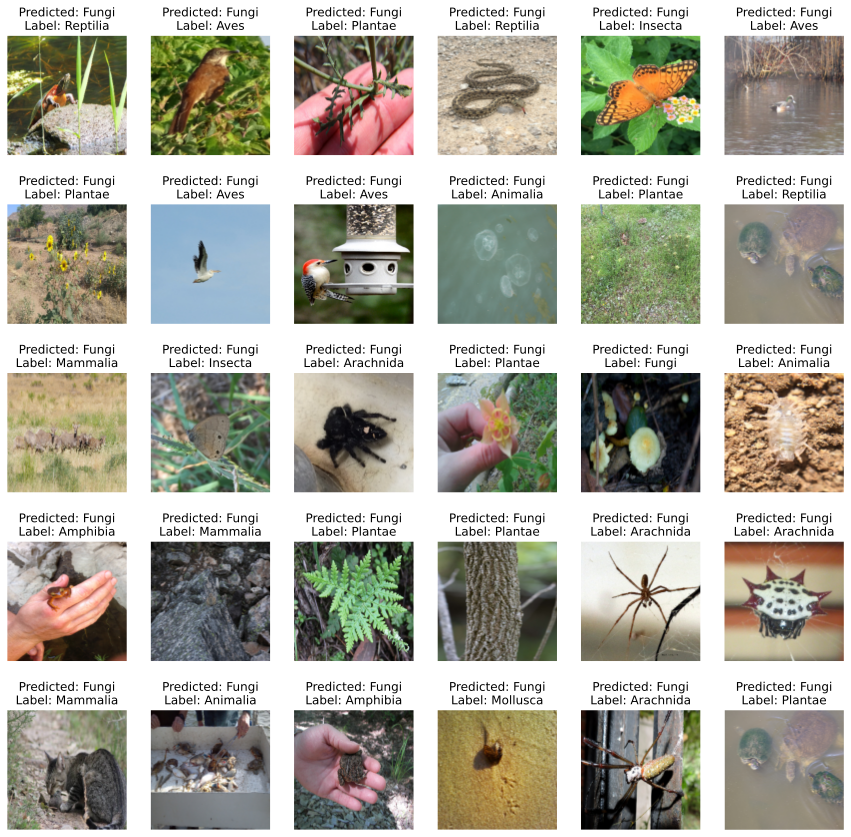

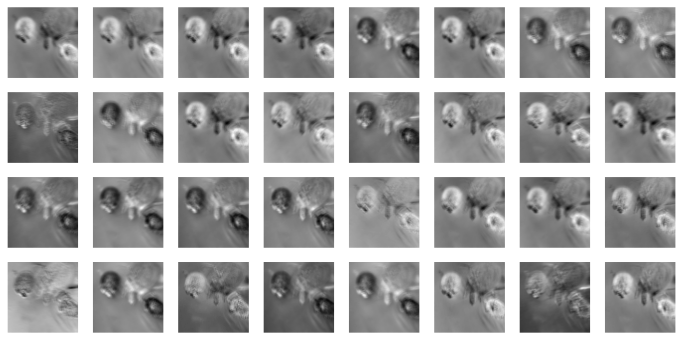

In [17]:
sweep_config = {
    "name": "test",
    "metric": "Val Accuracy",
    "method": "random",
    "parameters": {
        "num_filters": {
            "values": [32]
        },
        "filter_multiplier": {
            "values": [2]
        },
        "augment_data": {
            "values": [True]
        },
        "dropout": {
            "values": [0.3]
        },
        "batch_norm": {
            "values": [True]
        },
        "epochs": {
            "values": [1]
        },
        "dense_size": {
            "values": [64]
        },
        "lr": {
            "values": [0.001]
        },
        "epochs": {
            "values": [10]
        }
    }
}

# creating the sweep
sweep_id = wandb.sweep(sweep_config,entity="moni6264" ,project="test_10")
wandb.agent(sweep_id, function=test,count=1)
